In [1]:
### Acknowledgement
# The code and descriptions are originally written by Will Koehrsen
###################################################################

from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip drive/"My Drive"/DBIsubset.zip

Archive:  drive/My Drive/DBIsubset.zip
   creating: DBIsubset/
   creating: DBIsubset/bernese_mountain_dog/
  inflating: DBIsubset/bernese_mountain_dog/bernese1.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese10.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese100.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese11.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese12.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese13.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese14.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese15.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese16.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese17.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese18.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese19.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese2.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese20.jpg  
  inflating: DBIsubset/bernese_mountain_dog/bernese21

In [4]:
!unzip drive/"My Drive"/SDDsubset.zip

Archive:  drive/My Drive/SDDsubset.zip
   creating: SDDsubset/
   creating: SDDsubset/images/
   creating: SDDsubset/images/golden_retriever/
  inflating: SDDsubset/images/golden_retriever/n02099601_10.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_100.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_1010.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_1028.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_109.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_1162.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_118.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_124.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_1249.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_1259.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_1324.jpg  
  inflating: SDDsubset/images/golden_retriever/n02099601_14.jpg  
  inflating: SDDsubset/images/golden_retriever/n02

In [35]:
dataset = datasets.ImageFolder("DBIsubset")
print(len(dataset.classes))

7


In [36]:
random_seed = 45
torch.manual_seed(random_seed);

In [37]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

print(train_size, val_size, test_size)

408 45 193


In [38]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(len(train_ds), len(val_ds), len(test_ds))

408 45 193


In [39]:
train_ds.dataset.transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])

val_ds.dataset.transform = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_ds.dataset.transform = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [40]:
batch_size = 20

dataloaders = {
    'train': DataLoader(train_ds, batch_size = batch_size, shuffle=True),
    'val': DataLoader(val_ds, batch_size = batch_size, shuffle=True),
    'test': DataLoader(test_ds, batch_size = batch_size, shuffle=True)
}

In [41]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([20, 3, 224, 224]), torch.Size([20]))

In [42]:
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [43]:
def train(model,
          modelName,
          includeValPlot,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          test_loader,
          n_epochs=10,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    plt.title(f'Accuracies vs epoch for {modelName}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    valid_loss_min = np.Inf

    test_accuracy = 0
    valid_best_acc = 0
    history = []

    store_train_acc = []
    store_val_acc = []
    store_test_acc = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        test_accuracy = 0
        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()

            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                for data, target in test_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Calculate test accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    test_accuracy += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)
                test_accuracy = test_accuracy / len(dataloaders['test'].dataset)

                store_train_acc.append(train_acc)
                store_test_acc.append(test_accuracy)
                store_val_acc.append(valid_acc)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}% \t Test Accuracy: {100 * test_accuracy:.2f}%'
                )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    # Track improvement
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

    plt.plot(range(1, n_epochs + 1), store_train_acc, label = 'Train acc.')
    plt.plot(range(1, n_epochs + 1), store_test_acc, label = 'Test acc.')

    if includeValPlot:
      plt.plot(range(1, n_epochs + 1), store_val_acc, label = 'Validation acc.')

    plt.legend()

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [44]:
def reportTestAccuracyOnModel(model, test_loader):
  '''
  Return test accuracy as measured by the model in the test_loader
  '''

  test_acc = 0

  for data, target in test_loader:
    # Tensors to gpu
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    # Forward pass
    output = model(data)

    # Calculate test accuracy
    _, pred = torch.max(output, dim=1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    accuracy = torch.mean(
        correct_tensor.type(torch.FloatTensor))
    # Multiply average accuracy times the number of examples
    test_acc += accuracy.item() * data.size(0)

  test_acc = test_acc / len(test_loader.dataset)

  return(test_acc)

In [ ]:
# task 2

# defining the model with dropout

model = nn.Sequential(
                      nn.Conv2d(3, 16, 3),
                      nn.ReLU(),
                      nn.BatchNorm2d(16),
                      nn.Conv2d(16, 16, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Conv2d(16, 8, 3),
                      nn.ReLU(),
                      nn.BatchNorm2d(8),
                      nn.Conv2d(8, 8, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Dropout(0.2),
                      nn.Flatten(),
                      nn.Linear(22472, 32),
                      nn.Dropout(0.5),
                      nn.ReLU(),
                      nn.Linear(32, 7),
                      nn.Softmax(dim = 1)
        )
if train_on_gpu:
    model = model.to('cuda')

In [ ]:
# the optimizer was chosen to minimize the validation loss per epoch on average 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(model.parameters())

Starting Training from Scratch.



/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



Epoch: 0 	Training Loss: 1.9471 	Validation Loss: 1.9465
		Training Accuracy: 14.71%	 Validation Accuracy: 11.11% 	 Test Accuracy: 16.06%

Epoch: 1 	Training Loss: 1.9304 	Validation Loss: 1.9336
		Training Accuracy: 20.10%	 Validation Accuracy: 28.89% 	 Test Accuracy: 23.83%

Epoch: 2 	Training Loss: 1.8793 	Validation Loss: 1.9018
		Training Accuracy: 31.86%	 Validation Accuracy: 35.56% 	 Test Accuracy: 23.83%

Epoch: 3 	Training Loss: 1.8400 	Validation Loss: 1.8849
		Training Accuracy: 32.11%	 Validation Accuracy: 20.00% 	 Test Accuracy: 25.39%

Epoch: 4 	Training Loss: 1.7735 	Validation Loss: 1.8363
		Training Accuracy: 42.89%	 Validation Accuracy: 31.11% 	 Test Accuracy: 32.12%

Epoch: 5 	Training Loss: 1.7247 	Validation Loss: 1.8008
		Training Accuracy: 46.57%	 Validation Accuracy: 33.33% 	 Test Accuracy: 34.20%

Epoch: 6 	Training Loss: 1.6722 	Validation Loss: 1.8174
		Training Accuracy: 51.23%	 Validation Accuracy: 37.78% 	 Test Accuracy: 31.09%

Epoch: 7 	Training Loss: 1

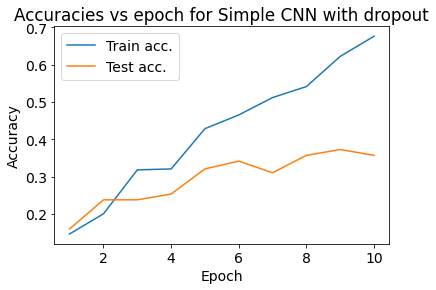

In [ ]:
model, history = train(
    model,
    'Simple CNN with dropout',
    False,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    dataloaders['test'],
    n_epochs = 10)

In [ ]:
# defining the model without dropout

model1 = nn.Sequential(
                      nn.Conv2d(3, 16, 3),
                      nn.ReLU(),
                      nn.BatchNorm2d(16),
                      nn.Conv2d(16, 16, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Conv2d(16, 8, 3),
                      nn.ReLU(),
                      nn.BatchNorm2d(8),
                      nn.Conv2d(8, 8, 3),
                      nn.ReLU(),
                      nn.MaxPool2d(2, 2),
                      nn.Flatten(),
                      nn.Linear(22472, 32),
                      nn.ReLU(),
                      nn.Linear(32, 7),
                      nn.Softmax(dim = 1)
        )

if train_on_gpu:
    model1 = model1.to('cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(model1.parameters())

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.9315 	Validation Loss: 1.9365
		Training Accuracy: 17.40%	 Validation Accuracy: 17.78% 	 Test Accuracy: 22.28%

Epoch: 1 	Training Loss: 1.8599 	Validation Loss: 1.8837
		Training Accuracy: 32.35%	 Validation Accuracy: 35.56% 	 Test Accuracy: 31.09%

Epoch: 2 	Training Loss: 1.7550 	Validation Loss: 1.7884
		Training Accuracy: 44.61%	 Validation Accuracy: 35.56% 	 Test Accuracy: 32.12%

Epoch: 3 	Training Loss: 1.6511 	Validation Loss: 1.7758
		Training Accuracy: 53.43%	 Validation Accuracy: 42.22% 	 Test Accuracy: 34.20%

Epoch: 4 	Training Loss: 1.5733 	Validation Loss: 1.8059
		Training Accuracy: 63.48%	 Validation Accuracy: 37.78% 	 Test Accuracy: 33.16%

Epoch: 5 	Training Loss: 1.4664 	Validation Loss: 1.8011
		Training Accuracy: 73.77%	 Validation Accuracy: 40.00% 	 Test Accuracy: 35.75%

Epoch: 6 	Training Loss: 1.3972 	Validation Loss: 1.8311
		Training Accuracy: 79.66%	 Validation Accuracy: 33.33% 	 Test Accuracy: 3

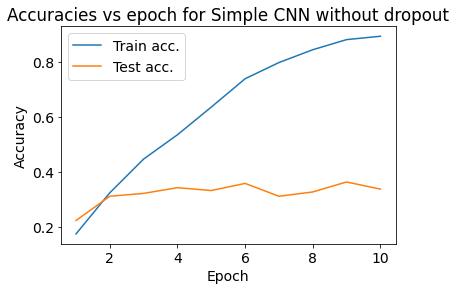

In [ ]:
model1, history = train(
    model1,
    'Simple CNN without dropout',
    False,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    dataloaders['test'],
    n_epochs = 10)

In [45]:
# task 3

# in tasks 3 and 4, the number of epochs were chosen such that the validation loss never increases for 3 consecutive epochs
# the optimizer is chosen since it gave the best validation loss per epoch on average as compared to other optimizers tried

model2 = models.resnet18()

In [ ]:
model2.fc = nn.Sequential(nn.Linear(512, 32), 
                          nn.ReLU(), nn.Dropout(0.2),
                          nn.Linear(32, 7),
                          nn.Softmax(dim = 1))

if train_on_gpu:
    model2 = model2.to('cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters())

Model has been trained for: 30 epochs.


Epoch: 0 	Training Loss: 1.8205 	Validation Loss: 1.8595
		Training Accuracy: 36.27%	 Validation Accuracy: 31.11% 	 Test Accuracy: 33.16%

Epoch: 1 	Training Loss: 1.7244 	Validation Loss: 1.8392
		Training Accuracy: 44.85%	 Validation Accuracy: 35.56% 	 Test Accuracy: 31.09%

Epoch: 2 	Training Loss: 1.7117 	Validation Loss: 1.8417
		Training Accuracy: 45.59%	 Validation Accuracy: 33.33% 	 Test Accuracy: 35.75%

Epoch: 3 	Training Loss: 1.6351 	Validation Loss: 1.7053
		Training Accuracy: 53.43%	 Validation Accuracy: 46.67% 	 Test Accuracy: 37.31%

Epoch: 4 	Training Loss: 1.6471 	Validation Loss: 1.7963
		Training Accuracy: 52.21%	 Validation Accuracy: 35.56% 	 Test Accuracy: 39.90%

Epoch: 5 	Training Loss: 1.6378 	Validation Loss: 1.8183
		Training Accuracy: 52.45%	 Validation Accuracy: 33.33% 	 Test Accuracy: 36.79%

Epoch: 6 	Training Loss: 1.6161 	Validation Loss: 1.8247
		Training Accuracy: 56.62%	 Validation Accuracy: 35.56% 	 Test Accu

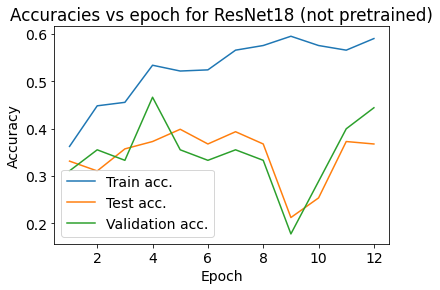

In [ ]:
model2, history = train(
    model2,
    'ResNet18 (not pretrained)',
    True,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    dataloaders['test'],
    n_epochs = 12)

In [51]:
testSDDdataset = datasets.ImageFolder("SDDsubset/images")
print(len(testSDDdataset))

test_SDD, dummy = random_split(testSDDdataset, [len(testSDDdataset), 0])
print(len(test_SDD), len(dummy))

1233
1233 0


In [52]:
test_SDD.dataset.transform = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [53]:
testLoader = DataLoader(test_SDD, batch_size = batch_size, shuffle=True)

In [ ]:
print(reportTestAccuracyOnModel(model2, dataloaders['test']))
print(reportTestAccuracyOnModel(model2, testLoader))

0.36787564627864816
0.3471208444501168


In [46]:
# task 4: we use monitored the validation loss and chose the number of epochs so that the validation loss never increases for 3 consecutive epochs
# other hyperparameters such as those in the last layer of the netowrks, and the optimizer, were chosen because they lead to lower validation losses per epoch on average
# as compared to other hyperparameters 

# We plot the training and test validation accuracies as in the previous tasks. 

# All models in this task are pre-trained with slight modifications to the last layer, where the weights have to be trained

# ResNet18
model3 = models.resnet18(weights="IMAGENET1K_V1")

# Freeze early layers
for param in model3.parameters():
    param.requires_grad = False

n_inputs = model3.fc.in_features
model3.fc = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 7), nn.Softmax(dim=1))



In [47]:
if train_on_gpu:
    model3 = model3.to('cuda')

if multi_gpu:
    model3 = nn.DataParallel(model3)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters())

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.6638 	Validation Loss: 1.3669
		Training Accuracy: 61.27%	 Validation Accuracy: 86.67% 	 Test Accuracy: 88.60%

Epoch: 1 	Training Loss: 1.3106 	Validation Loss: 1.2554
		Training Accuracy: 94.12%	 Validation Accuracy: 95.56% 	 Test Accuracy: 92.23%

Epoch: 2 	Training Loss: 1.2517 	Validation Loss: 1.2177
		Training Accuracy: 95.59%	 Validation Accuracy: 95.56% 	 Test Accuracy: 96.89%

Epoch: 3 	Training Loss: 1.2060 	Validation Loss: 1.2187
		Training Accuracy: 98.77%	 Validation Accuracy: 97.78% 	 Test Accuracy: 94.82%

Epoch: 4 	Training Loss: 1.2139 	Validation Loss: 1.2214
		Training Accuracy: 97.06%	 Validation Accuracy: 95.56% 	 Test Accuracy: 96.37%

Epoch: 5 	Training Loss: 1.2079 	Validation Loss: 1.2194
		Training Accuracy: 97.06%	 Validation Accuracy: 95.56% 	 Test Accuracy: 95.85%

Epoch: 6 	Training Loss: 1.1944 	Validation Loss: 1.2039
		Training Accuracy: 98.53%	 Validation Accuracy: 95.56% 	 Test Accuracy: 9

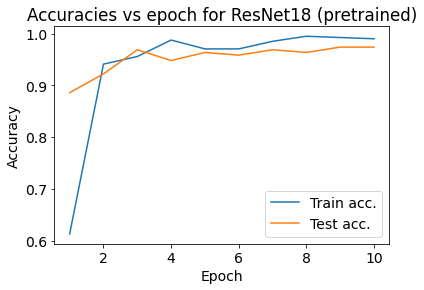

In [49]:
model3, history = train(
    model3,
    'ResNet18 (pretrained)',
    False,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    dataloaders['test'],
    n_epochs = 10)

In [54]:
print(reportTestAccuracyOnModel(model3, dataloaders['test']))
print(reportTestAccuracyOnModel(model3, testLoader))

0.9740932580720575
0.9107866906481648


In [55]:
# ResNet34
model4 = models.resnet34(weights="IMAGENET1K_V1")

# Freeze early layers
for param in model4.parameters():
    param.requires_grad = False

n_inputs = model4.fc.in_features
model4.fc = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 7), nn.Softmax(dim=1))

In [56]:
if train_on_gpu:
    model4 = model4.to('cuda')

if multi_gpu:
    model4 = nn.DataParallel(model4)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters())

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.6596 	Validation Loss: 1.3158
		Training Accuracy: 58.82%	 Validation Accuracy: 91.11% 	 Test Accuracy: 90.67%

Epoch: 1 	Training Loss: 1.2774 	Validation Loss: 1.1945
		Training Accuracy: 94.12%	 Validation Accuracy: 100.00% 	 Test Accuracy: 94.82%

Epoch: 2 	Training Loss: 1.2214 	Validation Loss: 1.1870
		Training Accuracy: 96.32%	 Validation Accuracy: 100.00% 	 Test Accuracy: 97.41%

Epoch: 3 	Training Loss: 1.2178 	Validation Loss: 1.2130
		Training Accuracy: 96.32%	 Validation Accuracy: 97.78% 	 Test Accuracy: 93.78%

Epoch: 4 	Training Loss: 1.2173 	Validation Loss: 1.1924
		Training Accuracy: 96.57%	 Validation Accuracy: 97.78% 	 Test Accuracy: 94.82%

Epoch: 5 	Training Loss: 1.1930 	Validation Loss: 1.1820
		Training Accuracy: 99.02%	 Validation Accuracy: 100.00% 	 Test Accuracy: 95.85%

Epoch: 6 	Training Loss: 1.1836 	Validation Loss: 1.1861
		Training Accuracy: 99.51%	 Validation Accuracy: 97.78% 	 Test Accuracy

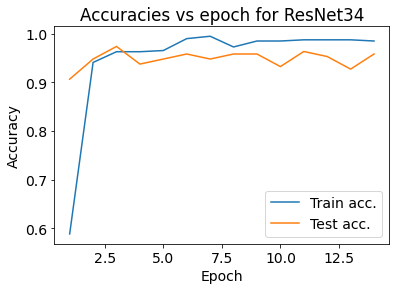

In [58]:
model4, history = train(
    model4,
    'ResNet34',
    False,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    dataloaders['test'],
    n_epochs = 14)

In [59]:
print(reportTestAccuracyOnModel(model4, dataloaders['test']))
print(reportTestAccuracyOnModel(model4, testLoader))

0.9585492144594538
0.9237631707295885


In [60]:
# ResNeXt32
model5 = models.resnext101_32x8d(weights="IMAGENET1K_V1")

# Freeze early layers
for param in model5.parameters():
    param.requires_grad = False

n_inputs = model5.fc.in_features
model5.fc = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 7), nn.Softmax(dim=1))

In [61]:
if train_on_gpu:
    model5 = model5.to('cuda')

if multi_gpu:
    model5 = nn.DataParallel(model5)

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters())

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.5409 	Validation Loss: 1.2850
		Training Accuracy: 67.16%	 Validation Accuracy: 88.89% 	 Test Accuracy: 84.97%

Epoch: 1 	Training Loss: 1.3391 	Validation Loss: 1.3092
		Training Accuracy: 83.82%	 Validation Accuracy: 86.67% 	 Test Accuracy: 81.87%

Epoch: 2 	Training Loss: 1.3141 	Validation Loss: 1.2757
		Training Accuracy: 86.27%	 Validation Accuracy: 88.89% 	 Test Accuracy: 83.94%

Epoch: 3 	Training Loss: 1.2621 	Validation Loss: 1.2368
		Training Accuracy: 90.20%	 Validation Accuracy: 95.56% 	 Test Accuracy: 92.23%

Epoch: 4 	Training Loss: 1.2225 	Validation Loss: 1.1789
		Training Accuracy: 96.32%	 Validation Accuracy: 100.00% 	 Test Accuracy: 98.45%

Epoch: 5 	Training Loss: 1.1833 	Validation Loss: 1.1899
		Training Accuracy: 99.02%	 Validation Accuracy: 97.78% 	 Test Accuracy: 97.93%

Epoch: 6 	Training Loss: 1.1883 	Validation Loss: 1.1906
		Training Accuracy: 98.77%	 Validation Accuracy: 97.78% 	 Test Accuracy: 

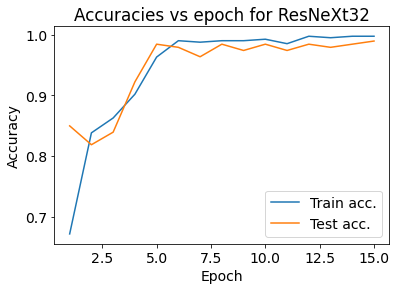

In [63]:
model5, history = train(
    model5,
    'ResNeXt32',
    False,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    dataloaders['test'],
    n_epochs = 15)

In [64]:
print(reportTestAccuracyOnModel(model5, dataloaders['test']))
print(reportTestAccuracyOnModel(model5, testLoader))

0.989637303228823
0.9772911543587022


In [65]:
!unzip drive/"My Drive"/task5.zip

Archive:  drive/My Drive/task5.zip
replace task5/DBIsubset/bernese1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [67]:
# task 5

dataset = datasets.ImageFolder("task5")
print(len(dataset.classes))

test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

print(train_size, val_size, test_size)

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(len(train_ds), len(val_ds), len(test_ds))

2
1185 131 563
1185 131 563


In [68]:
train_ds.dataset.transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])

val_ds.dataset.transform = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_ds.dataset.transform = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [69]:
batch_size = 50

dataloaders = {
    'train': DataLoader(train_ds, batch_size = batch_size, shuffle=True),
    'val': DataLoader(val_ds, batch_size = batch_size, shuffle=True),
    'test': DataLoader(test_ds, batch_size = batch_size, shuffle=True)
}

In [70]:
# using pre-trained model

# ResNeXt32
model6 = models.resnext101_32x8d(weights="IMAGENET1K_V1")

# Freeze early layers
for param in model6.parameters():
    param.requires_grad = False

n_inputs = model6.fc.in_features
model6.fc = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2), nn.Softmax(dim=1))

In [71]:
if train_on_gpu:
    model6 = model6.to('cuda')

if multi_gpu:
    model6 = nn.DataParallel(model6)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model6.parameters(), lr = 0.1)

# the optimizer is chosen as above since on average it leads to the lowest validation loss per epoch as compared to other optimizers tried.

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.6191 	Validation Loss: 0.5960
		Training Accuracy: 66.84%	 Validation Accuracy: 67.18% 	 Test Accuracy: 66.07%

Epoch: 1 	Training Loss: 0.5703 	Validation Loss: 0.5485
		Training Accuracy: 74.18%	 Validation Accuracy: 78.63% 	 Test Accuracy: 79.40%

Epoch: 2 	Training Loss: 0.5538 	Validation Loss: 0.5233
		Training Accuracy: 74.26%	 Validation Accuracy: 78.63% 	 Test Accuracy: 76.02%

Epoch: 3 	Training Loss: 0.5213 	Validation Loss: 0.5799
		Training Accuracy: 79.32%	 Validation Accuracy: 72.52% 	 Test Accuracy: 73.89%

Epoch: 4 	Training Loss: 0.5203 	Validation Loss: 0.6035
		Training Accuracy: 78.40%	 Validation Accuracy: 68.70% 	 Test Accuracy: 71.05%

Epoch: 5 	Training Loss: 0.4888 	Validation Loss: 0.4970
		Training Accuracy: 82.53%	 Validation Accuracy: 83.21% 	 Test Accuracy: 80.46%

Epoch: 6 	Training Loss: 0.4786 	Validation Loss: 0.5420
		Training Accuracy: 83.21%	 Validation Accuracy: 77.86% 	 Test Accuracy: 7

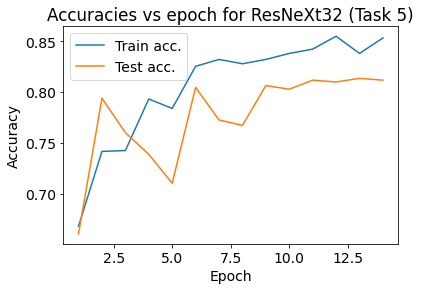

In [73]:
# we choose the number of epochs as 14 because after that the validation loss starts to increase fairly often

model6, history = train(
    model6,
    'ResNeXt32 (Task 5)',
    False,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    dataloaders['test'],
    n_epochs = 14)

In [74]:
print(reportTestAccuracyOnModel(model6, dataloaders['test']))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


0.8117229003677572
